#  *** DRAFT ***
##### Author: Omer Nivron
##### Date: 04/09/19

# Predict whether or not it will rain tomorrow in Australia

####  Data source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package 

### Plan

1. Data cleanup
 - Formatting issues
 - Duplicates
 - Missing values
 
2. Exploration
 - visualizations
 
3. Feature Engineering
 - transform categorical features
 - 
 -

4. Modeling
    - Decision tree classifier
    - Random forest classifier

5. Evalution
    - misclassification error
    - feature importance

### Import packages

In [1]:
import pandas as pd
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, ensemble
from datetime import datetime
from datetime import date
import time
import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
def extract_year_mon_day_cols_from_date_col(df):
    df['Year'], df['Month'], df['Day'] = df['Date'].dt.year, df['Date'].dt.month, df['Date'].dt.day
    return df

In [3]:
def remove_miss_col_with_bigger_than_share(df, share):
    df = df.loc[:, (df.isnull().sum(axis=0) / df.shape[0]) <= share]
    
    return df

In [4]:
def get_mode_col_w_missing_vals(df, col_name, groupby_cols = None):
    mode = df[groupby_cols + [col_name]][~df[col_name].isna()].groupby(groupby_cols) \
    .agg(lambda x: scipy.stats.mode(x)[0])[col_name].reset_index()
    # merge with df
    df = pd.merge(df, mode, on=groupby_cols, suffixes=('', '_mode'))
    return df

In [5]:
def get_median_col_w_missing_vals(df, col_name, groupby_cols = None):
    median = df[groupby_cols + [col_name]][~df[col_name] \
                                                               .isna()].groupby(groupby_cols) \
                                                            .median()[col_name].reset_index()
    # merge with df
    df = pd.merge(df, median, on=groupby_cols, suffixes=('', '_median'))
    return df

In [6]:
def wrapper_median_mode_df(df): 
    for column in list(df.columns[df.isna().sum() > 0]):
        if df[column].dtype == 'O':
            df = get_mode_col_w_missing_vals(df, column, ['Location','Year','Month'])
            df = if_na_get_mode_or_median(df, column, func = 'mode')
        else:
            df = get_median_col_w_missing_vals(df, column, ['Location','Year','Month'])
            df = if_na_get_mode_or_median(df, column, func = 'median')
    return df

In [7]:
def if_na_get_mode_or_median(df, col_name, func = 'mode'):
    df.loc[df[col_name].isna(), col_name] = df[df[col_name].isna()][col_name + '_' + func]
    df = df.drop(col_name + '_' + func, axis=1)
    return df

In [8]:
def if_no_rainToday_zero_rainfall(df):
    df['Rainfall'] = df[['Rainfall', 'RainToday']].apply(lambda x: x['Rainfall'] \
                                                                          if x['RainToday'] == 'Yes' else 0 , axis =1)
    
    return df

In [9]:
def transform_string_to_date(pd_series):
    pd_series = pd_series.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return pd_series

In [10]:
def transform_yes_no_col_to_binary(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: 1 if x == 'Yes' else 0)
    return df

In [11]:
def transform_to_dummies(df, cols):
    dummies =  pd.get_dummies(df[cols])
    df = df.drop(cols, axis =1)
    df = pd.concat([df, dummies], axis=1)
    return df

In [12]:
def tr_te_split(df, traget_col, cond_col, cond):
    index_split = df[cond_col] > cond
    tr_x, tr_y, te_x, te_y = df.loc[index_split, df.columns != traget_col], \
    df.loc[index_split, traget_col], df.loc[~index_split, df.columns != traget_col], \
    df.loc[~index_split, traget_col] 
    
    return tr_x, tr_y, te_x, te_y

In [13]:
def calc_misclass_error(pred, target):
    error = np.where((pred == target) == False)[0].shape[0]/ target.shape[0]
    return error

### Read data 

In [14]:
australian_rain_df = pd.read_csv('weatherAUS.csv')

#### Data statistics - get sense what values we have 

In [15]:
australian_rain_df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.000000      13.000000   
50%        8.500000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  140419.000000  138583.000000  128179.000000  128212.000000   
mean       68.843810      51.482606    1017.653758    1015.258204   
std        19.051293      20.797772       7.105476       7.036677   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      37.000000    1012.900000    1010.400000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      66.000000    1022.400000    1020.000000   
max       100.000000     100.000000    1041.000000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am        Temp3pm        RISK_MM  
count  88536.000000  85099.000000  141289.000000  139467.000000  142193.000000  
mean       4.437189      4.503167      16.987509      21.687235       2.360682  
std        2.887016      2.720633       6.492838       6.937594       8.477969  
min        0.000000      0.000000      -7.200000      -5.400000       0.000000  
25%        1.000000      2.000000      12.300000      16.600000       0.000000  
50%        5.000000      5.000000      16.700000      21.100000       0.000000  
75%        7.000000      7.000000      21.600000      26.400000       0.800000  
max        9.000000      9.000000      40.200000      46.700000     371.000000

### Data cleaning

##### According to kaggle we should remove the column RISK_MM

In [16]:
australian_rain_df = australian_rain_df.drop('RISK_MM', axis=1)

#### Formatting - here we check the type each column has and change it if needed

In [17]:
pd.DataFrame(australian_rain_df.dtypes).transpose()

Date Location  MinTemp  MaxTemp Rainfall Evaporation Sunshine  \
0  object   object  float64  float64  float64     float64  float64   

  WindGustDir WindGustSpeed WindDir9am  ... Humidity9am Humidity3pm  \
0      object       float64     object  ...     float64     float64   

  Pressure9am Pressure3pm Cloud9am Cloud3pm  Temp9am  Temp3pm RainToday  \
0     float64     float64  float64  float64  float64  float64    object   

  RainTomorrow  
0       object  

[1 rows x 23 columns]

##### Let's check the type of the object columns

In [18]:
list(map(type, australian_rain_df.columns[australian_rain_df.dtypes == 'object']))

[str, str, str, str, str, str, str]

##### 1. Change Date column to date type and extract year, month and day columns



In [19]:
australian_rain_df['Date'] = transform_string_to_date(australian_rain_df['Date'])
australian_rain_df = extract_year_mon_day_cols_from_date_col(australian_rain_df)

##### 2. Change RainToday and RainTomorrow to 0/1 instead Yes/No
Preform this step only after treating the missing values (uncomment) 

In [20]:
# australian_rain_df = transform_yes_no_col_to_binary(australian_rain_df, 'RainToday')
# australian_rain_df = transform_yes_no_col_to_binary(australian_rain_df, 'RainTomorrow')

#### Duplicates - are there any repeating dates per location ? 

In [21]:
print("There are " + str(sum(australian_rain_df.duplicated(subset=['Date','Location'], keep=False))) + " duplicated dates here!")

There are 0 duplicated dates here!


##### Let's drop the Date column (we have the Year, Month and Day instead)

In [22]:
australian_rain_df = australian_rain_df.drop('Date', axis=1)

#### Missing values - imputation

In [23]:
 pd.DataFrame({'Missing_abs':[australian_rain_df.isna().sum()][0], \
               'Missing_share':[australian_rain_df.isna().sum() / australian_rain_df.shape[0]][0]}).transpose()

Location    MinTemp     MaxTemp     Rainfall  Evaporation  \
Missing_abs         0.0  637.00000  322.000000  1406.000000  60843.00000   
Missing_share       0.0    0.00448    0.002265     0.009888      0.42789   

                   Sunshine  WindGustDir  WindGustSpeed    WindDir9am  \
Missing_abs    67816.000000  9330.000000    9270.000000  10013.000000   
Missing_share      0.476929     0.065615       0.065193      0.070418   

               WindDir3pm  ...   Pressure3pm      Cloud9am      Cloud3pm  \
Missing_abs    3778.00000  ...  13981.000000  53657.000000  57094.000000   
Missing_share     0.02657  ...      0.098324      0.377353      0.401525   

                  Temp9am      Temp3pm    RainToday  RainTomorrow  Year  \
Missing_abs    904.000000  2726.000000  1406.000000           0.0   0.0   
Missing_share    0.006358     0.019171     0.009888           0.0   0.0   

               Month  Day  
Missing_abs      0.0  0.0  
Missing_share    0.0  0.0  

[2 rows x 25 columns]

##### Let's remove columns with missing value share greater than 0.35

In [24]:
australian_rain_df = remove_miss_col_with_bigger_than_share(australian_rain_df, 0.35)

For the remaining columns with missing values if it's a categorical column we get the mode per location, year and month. If it is numeric column we get the median per location, year and month. After, We will enforce if there was no rain today then Rainfall equals 0.

In [25]:
australian_rain_df = wrapper_median_mode_df(australian_rain_df)
australian_rain_df = if_no_rainToday_zero_rainfall(australian_rain_df)

In [26]:
df = australian_rain_df

### Exploration

In [27]:
# let's look at how many data points we have from each location
# This might be important to decide on an appropriate threshold for train/test split and also 
# to understand where are our blinspots 
pd.DataFrame(australian_rain_df[['Year','Month', 'Day', 'Location']].groupby('Location').size()).reset_index().transpose()

0       1             2              3         4        5   \
Location  Adelaide  Albury  AliceSprings  BadgerysCreek  Ballarat  Bendigo   
0             3090    3011          3031           2837      3028     3034   

                6       7         8      9   ...          34           35  \
Location  Brisbane  Cairns  Canberra  Cobar  ...  Townsville  Tuggeranong   
0             3161    2988      3206   2905  ...        3033         2998   

             36          37       38        39           40           41  \
Location  Uluru  WaggaWagga  Walpole  Watsonia  Williamtown  Witchcliffe   
0          1521        2976     2819      2999         2553         2676   

                  42       43  
Location  Wollongong  Woomera  
0               2983     2990  

[2 rows x 44 columns]

<h1 style="color:blue;"> USER INPUT -  Change location/month to see other distributions  </h1>

In [28]:
loc = 'Adelaide'
mon = 4

##### For numeric variables let's plot boxplots per location and month

In [29]:
numeric_cols = australian_rain_df.columns[australian_rain_df.dtypes == 'float64']
cat_cols = australian_rain_df.columns[australian_rain_df.dtypes == 'object'][1:]

<AxesSubplot:title={'center':'WindGustSpeed'}, xlabel='[Month]'>

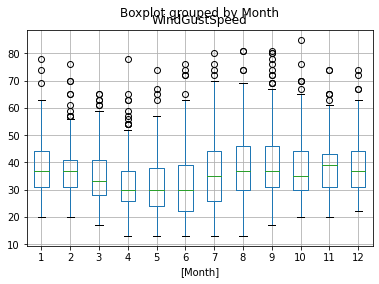

In [30]:
# for num_var in numeric_cols:
df[df['Location'] == loc].boxplot(column='WindGustSpeed', by =['Month'])

##### Let's explore the correlations between variable pairs

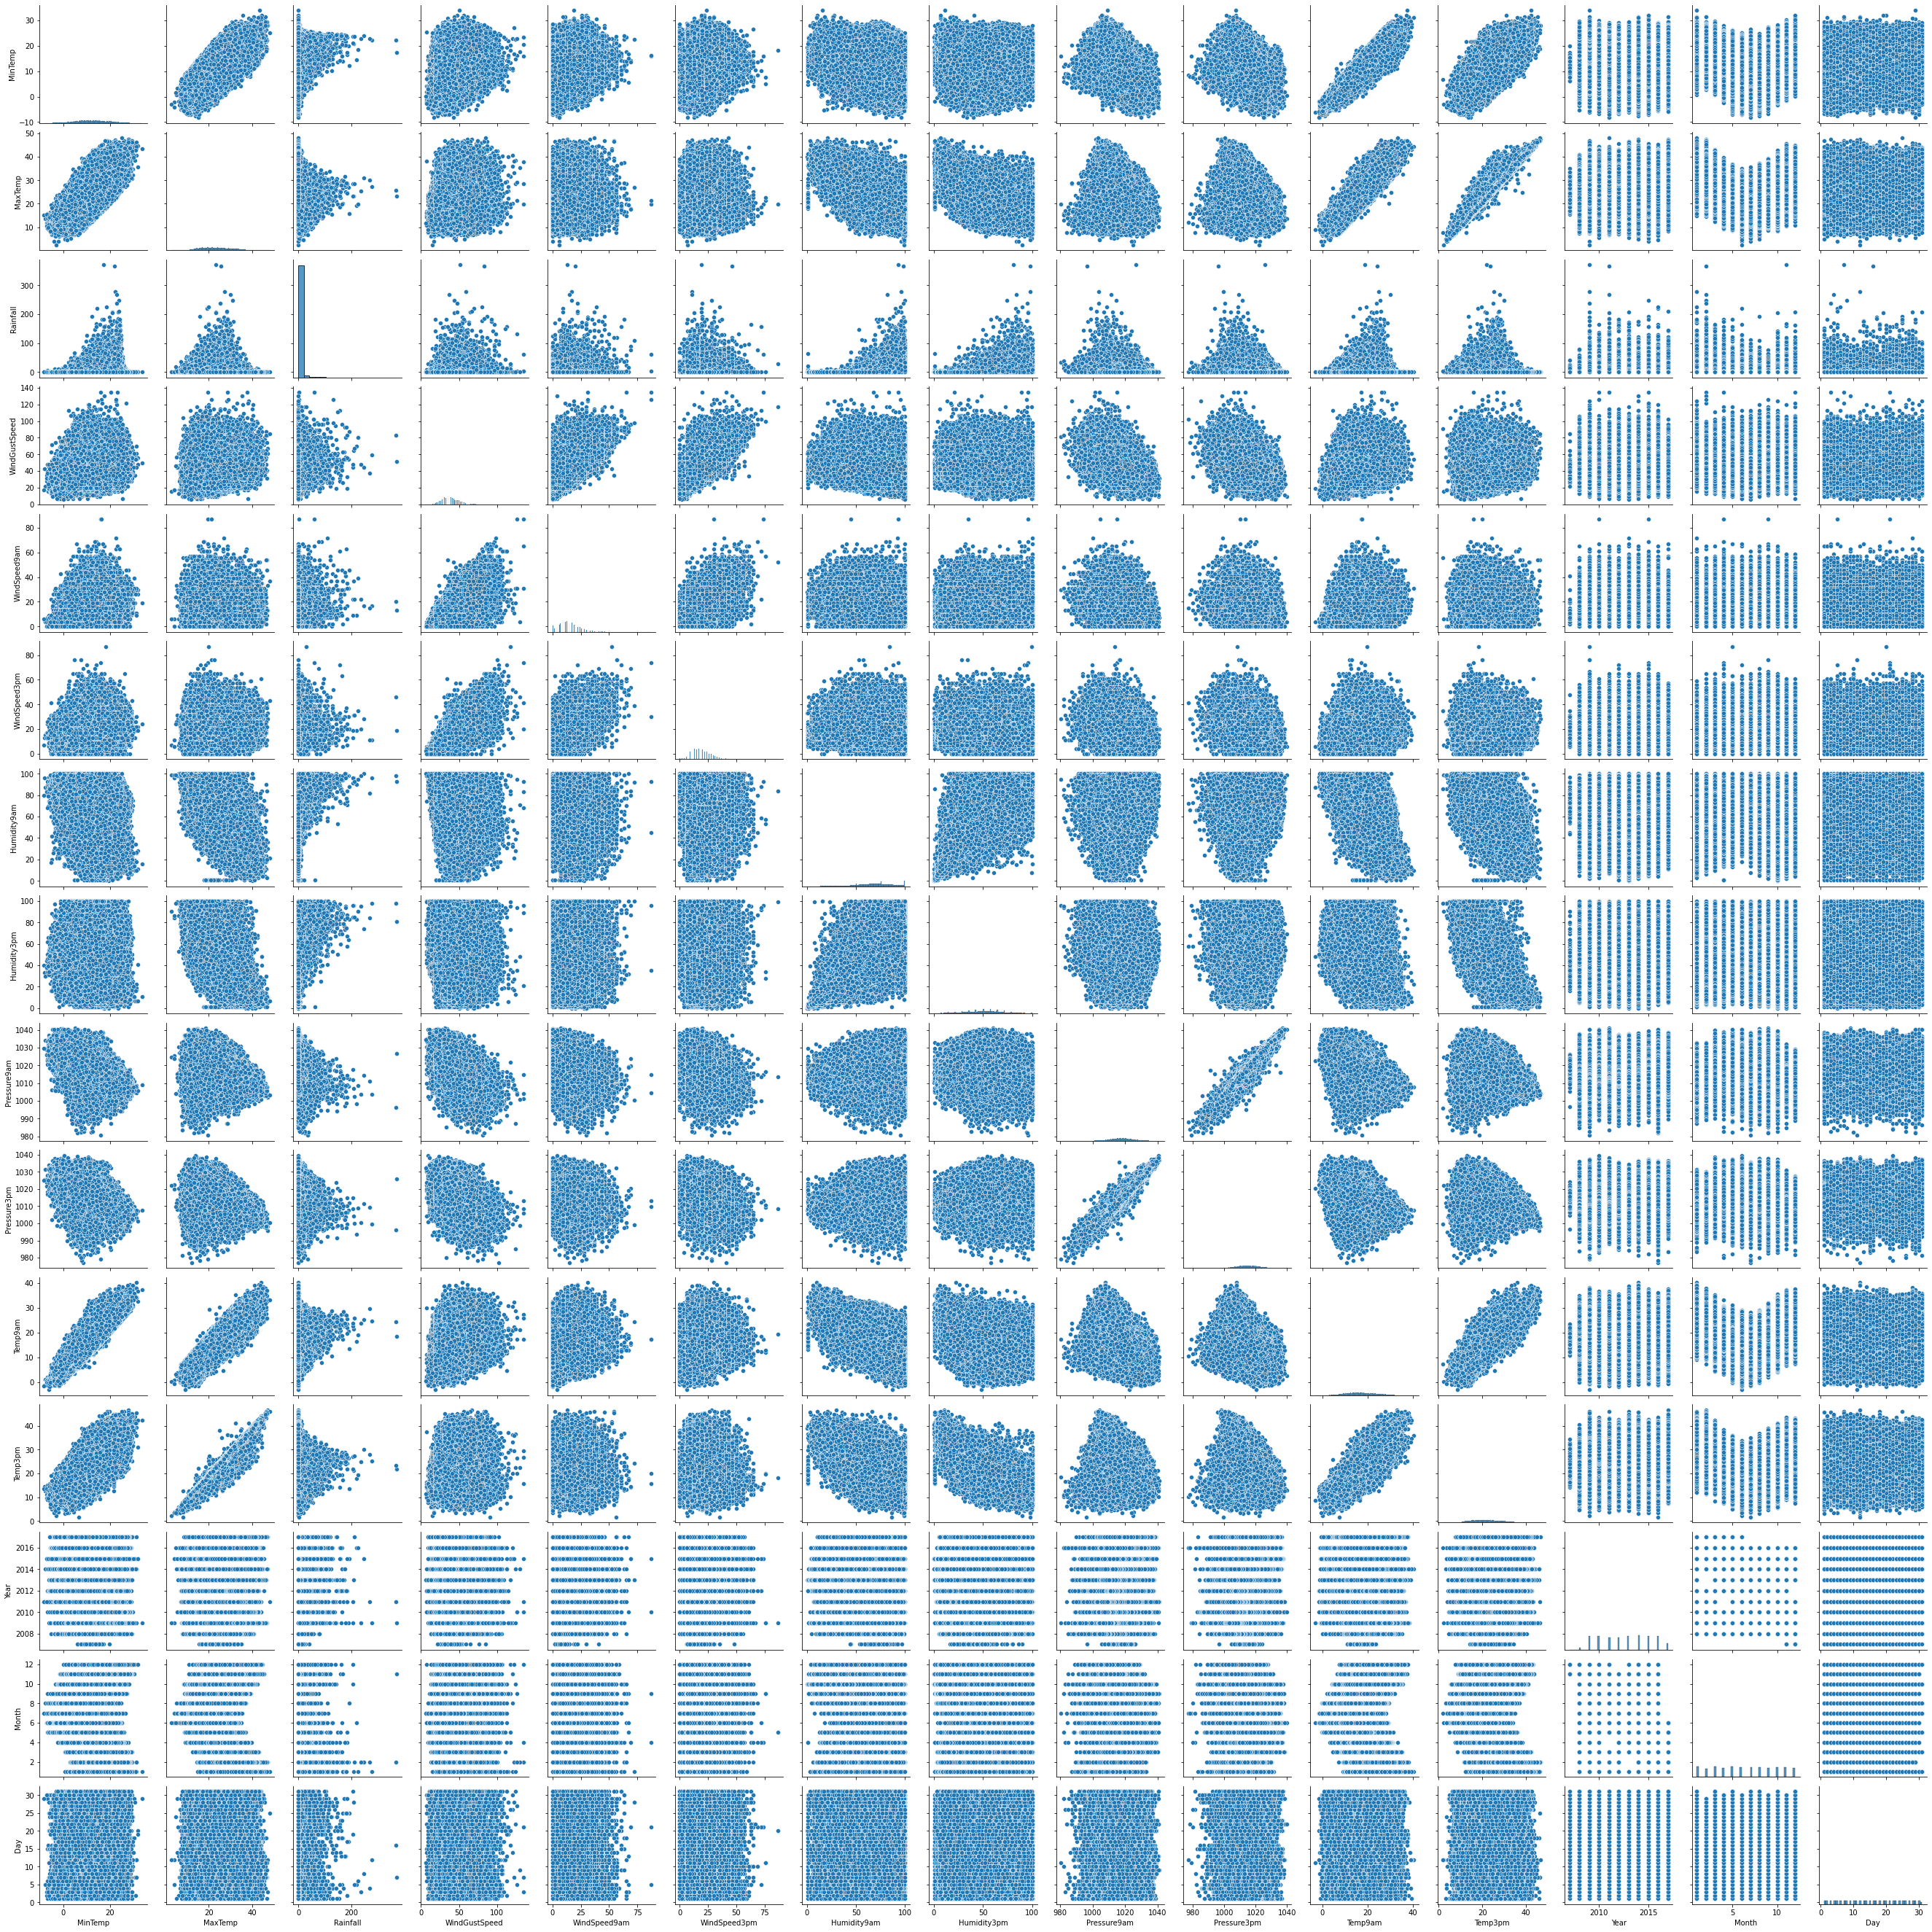

In [31]:
sns.pairplot(df)

##### For categorical variables let's plot bar graphs 

In [32]:
wind_gust_bar_data = australian_rain_df.loc[australian_rain_df['Location'] == loc, ['Location', 'WindGustDir', 'Month']].groupby(['WindGustDir','Month']).count().reset_index()
wind_dir3pm_bar_data = australian_rain_df.loc[australian_rain_df['Location'] == loc, ['Location', 'WindDir3pm', 'Month']].groupby(['WindDir3pm','Month']).count().reset_index()
wind_dir9am_bar_data = australian_rain_df.loc[australian_rain_df['Location'] == loc, ['Location', 'WindDir9am', 'Month']].groupby(['WindDir9am','Month']).count().reset_index()

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(18, 11))
plt.subplot(2, 2, 1)
plt.bar(wind_gust_bar_data.loc[wind_gust_bar_data['Month'] == mon,'WindGustDir'], wind_gust_bar_data.loc[wind_gust_bar_data['Month'] == 4, 'Location'], color='b')
plt.title('Count of wind direction gust at Adelaide during April')

plt.subplot(2, 2, 2)
plt.bar(wind_dir9am_bar_data.loc[wind_dir9am_bar_data ['Month'] == mon,'WindDir9am'], wind_dir9am_bar_data.loc[wind_dir9am_bar_data['Month'] == 4, 'Location'], color= 'g')
plt.title('Count of wind direction 9am at Adelaide during April')

plt.subplot(2, 2, 3)
plt.bar(wind_dir3pm_bar_data.loc[wind_dir3pm_bar_data['Month'] == mon,'WindDir3pm'], wind_dir3pm_bar_data.loc[wind_dir3pm_bar_data['Month'] == 4, 'Location'], color= 'y')
plt.title('Count of wind direction 3pm at Adelaide during April')

fig.delaxes(axes[1][1])

### Feature engineering

In [ ]:
australian_rain_df = transform_to_dummies(australian_rain_df, list(cat_cols) + ['Location'])

### Modelling - decision tree and random forest classifiers

In [ ]:
def model():
    feat_importance = {}
    results = {'Model': ['-'], 'Training misclassification': ['-'], 'Test misclassification': ['-'], 'Runtime': ['-']}
    results_pd = pd.DataFrame(data = results)
    models = ['Tree', 'Random forest']
    # split to training data and test data
    tr_x, tr_y, te_x, te_y = tr_te_split(australian_rain_df, 'RainTomorrow', 'Year', 2014)
    for kind in models:
        start = time.time()
        if kind == 'Tree':
            model = tree.DecisionTreeClassifier()
        else : 
            model = ensemble.RandomForestClassifier()
        
        model = model.fit(tr_x, tr_y)
        predict_tr = model.predict(tr_x)
        predict_te = model.predict(te_x)
        tr_err, te_err = calc_misclass_error(predict_tr, tr_y), calc_misclass_error(predict_te, te_y)
        feat_importance[kind] = model.feature_importances_
        end = time.time()
        runtime = round((end - start) / 60, 2)
        
        
        
        results_pd = results_pd.append(pd.DataFrame({'Model': [kind], 'Training misclassification': [str(round(tr_err, 2))], 
                                            'Test misclassification': [str(round(te_err, 2))], 'Runtime': [runtime]}))
        
    return feat_importance, results_pd

### Evaluation

In [ ]:
feat_importance, results_pd = model()

In [ ]:
results_pd.reset_index(drop=True)

In [ ]:
df = australian_rain_df.drop('RainTomorrow', axis=1)

In [ ]:
print('The top three features for the decision tree model are:' + ' ' + ', '.join(list(df.columns[feat_importance['Tree'].argsort()[:3]])))
print('The top three features for the Random Forest model are:' + ' ' + ', '.join(list(df.columns[feat_importance['Random forest'].argsort()[:3]])))

### It seems like we have a major overfit here ! 